In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchviz import make_dot
from graphviz import Digraph
from IPython.display import Image, display
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import importlib
import ic
#importlib.reload(ic)
# Do you have a GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#  Add path for Graphviz if necessary
if os.pathsep + r"C:\Program Files\Graphviz\bin" in os.environ["PATH"]:
    pass
else:
    os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

#  The MNIST Data Set

In this example, we will be using Pytorch to train a neural network to recognize handwritten numerals.  These are stored in the MNIST dataset as 28 x 28 greyscale images:

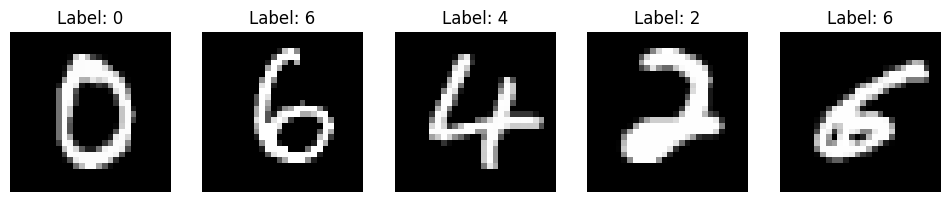

In [6]:
ic.print_examples()

#  Using Rectified Linear Unit Activation

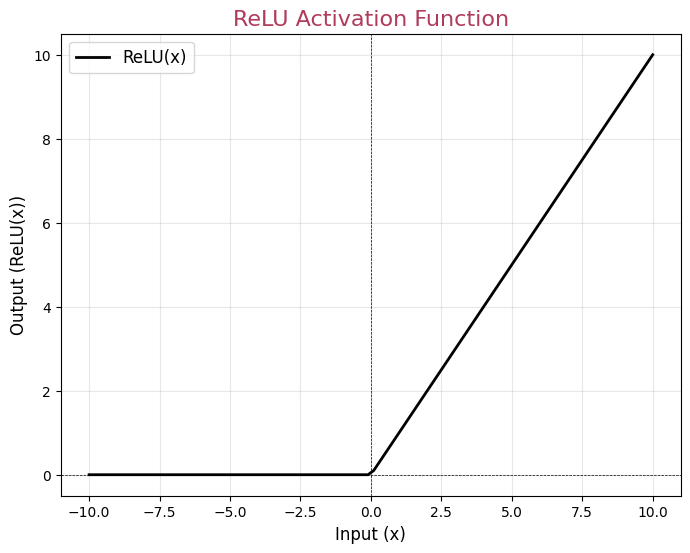

In [8]:
x = torch.linspace(-10, 10, 100)  # 100 points between -10 and 10
activation = torch.nn.ReLU()
label = 'ReLU'

ic.plot_activation(x,relu = activation , lbl = label)

In [10]:
# Step 1: Load and preprocess the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [12]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# Define the model, loss function and optimizer
model = ic.SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [18]:
#  Train Model
ic.train_model(model, optimizer, criterion, train_loader)

epochs to run: 5
Epoch 1/5, Loss: 0.3966
Epoch 2/5, Loss: 0.1932
Epoch 3/5, Loss: 0.1431
Epoch 4/5, Loss: 0.1168
Epoch 5/5, Loss: 0.0959


In [20]:
# Evaluate the model
# Evaluate on training and test data
train_acc = ic.evaluate_accuracy(model, train_loader, device)
test_acc = ic.evaluate_accuracy(model, test_loader, device)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 97.66%
Test Accuracy: 96.59%


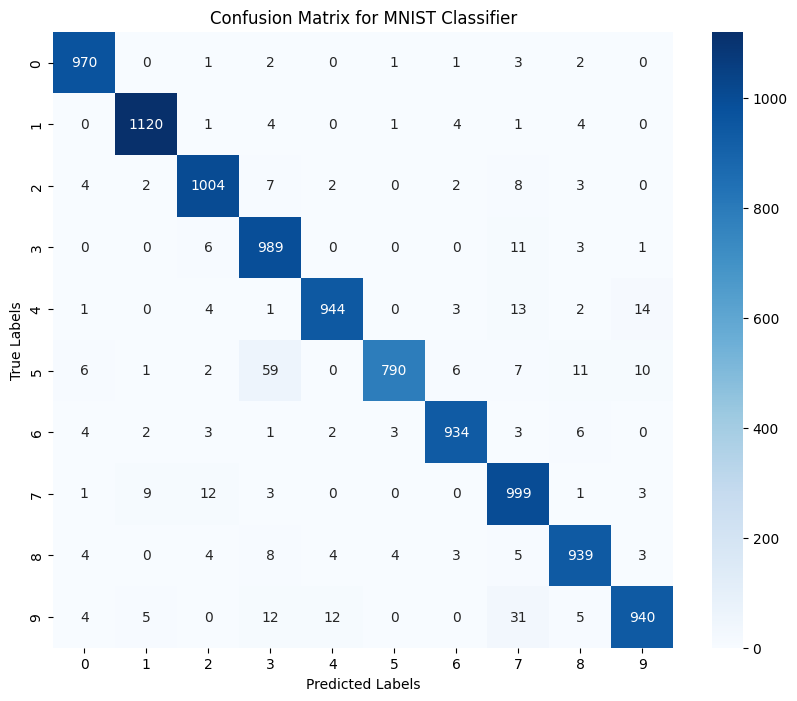

In [19]:
# Let's have a look at the MNIST test data and generate a confusion matrix:
# Get the true and predicted labels
true_labels, predicted_labels = ic.evaluate_model(model, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MNIST Classifier')
plt.show()

In [20]:
# counting dead neurons
# Generate some dummy input data
dummy_data = torch.randn(100, 1, 28, 28)  # Batch of 100 MNIST-like images

# Perform a forward pass and count dead neurons
with torch.no_grad():
    _ = model(dummy_data)

    # Check dead neurons for the first layer
    dead_neurons_fc1 = (model.activations_fc1 == 0).all(dim=0).sum().item()
    total_neurons_fc1 = model.activations_fc1.shape[1]
    print(f"Layer 1: {dead_neurons_fc1}/{total_neurons_fc1} neurons are dead.")

    # Check dead neurons for the second layer
    dead_neurons_fc2 = (model.activations_fc2 == 0).all(dim=0).sum().item()
    total_neurons_fc2 = model.activations_fc2.shape[1]
    print(f"Layer 2: {dead_neurons_fc2}/{total_neurons_fc2} neurons are dead.")

Layer 1: 0/128 neurons are dead.
Layer 2: 8/64 neurons are dead.


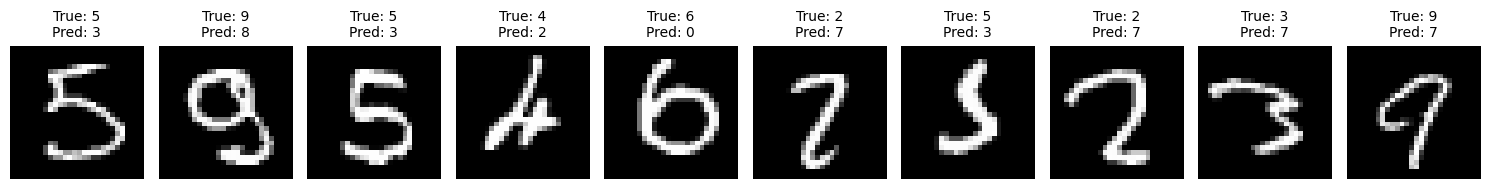

In [21]:
# examples of mislabeled numbers
ic.plot_mislabeled_images(model, test_loader, device, num_examples=10)

# Using Leaky Rectified Linear Unit

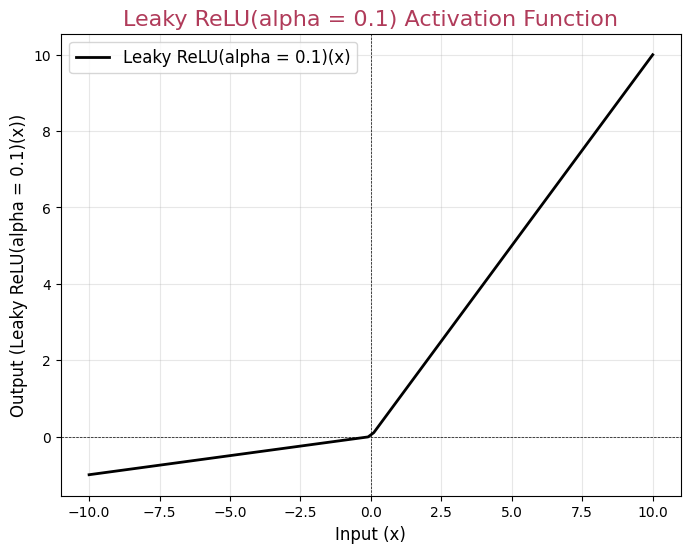

In [23]:
x = torch.linspace(-10, 10, 100)  # 100 points between -10 and 10
activation = torch.nn.LeakyReLU(negative_slope=0.1) 
label = 'Leaky ReLU(alpha = 0.1)'

ic.plot_activation(x,relu = activation , lbl = label)

In [25]:
# Step 2: Define the model
model_leak = ic.SimpleNN(activation_function=lambda: nn.LeakyReLU(negative_slope=0.01))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_leak.parameters(), lr=0.001)
summary(model_leak, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
         LeakyReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [27]:
#  Train Model
ic.train_model(model_leak, optimizer, criterion, train_loader)

epochs to run: 5
Epoch 1/5, Loss: 0.4063
Epoch 2/5, Loss: 0.1860
Epoch 3/5, Loss: 0.1341
Epoch 4/5, Loss: 0.1082
Epoch 5/5, Loss: 0.0904


In [28]:
train_acc = ic.evaluate_accuracy(model_leak, train_loader, device)
test_acc = ic.evaluate_accuracy(model_leak, test_loader, device)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 97.20%
Test Accuracy: 96.62%


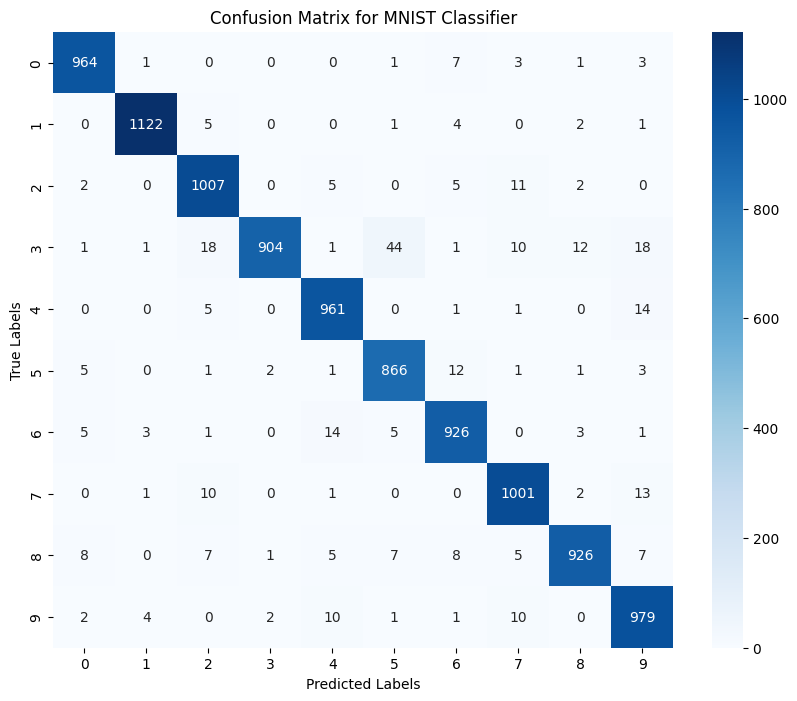

In [27]:
# Let's have a look at the MNIST test data and generate a confusion matrix:
# Get the true and predicted labels
true_labels, predicted_labels = ic.evaluate_model(model_leak, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MNIST Classifier')
plt.show()

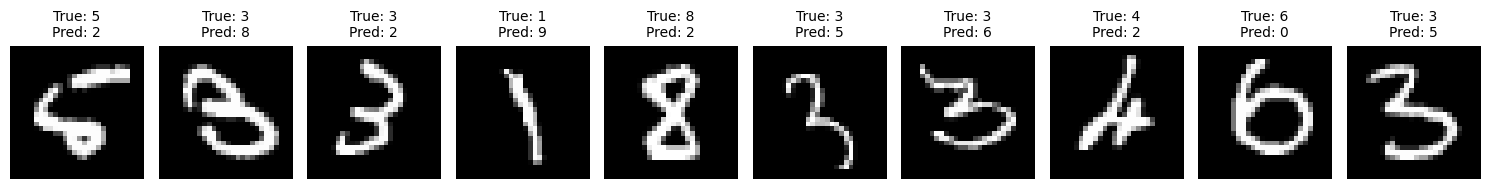

In [28]:
# examples of mislabeled numbers
ic.plot_mislabeled_images(model_leak, test_loader, device, num_examples=10)

# Using Exponential Linear Unit (ELU) Activation 

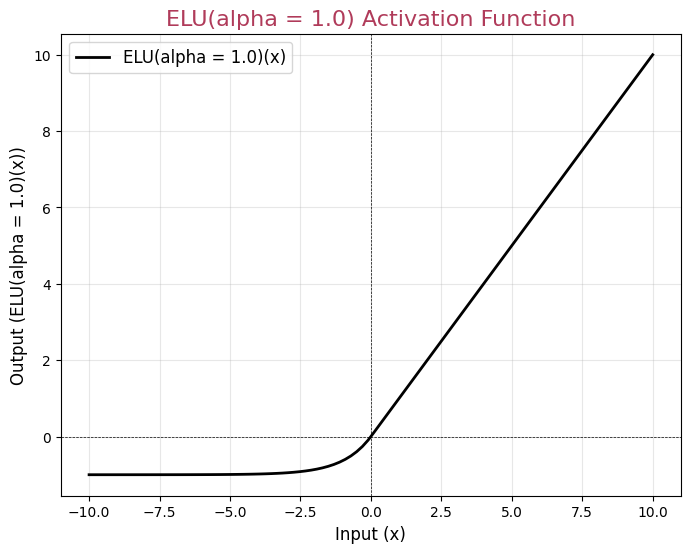

In [30]:
x = torch.linspace(-10, 10, 100)  # 100 points between -10 and 10
activation = torch.nn.ELU(alpha=1.0) 
label = 'ELU(alpha = 1.0)'

ic.plot_activation(x,relu = activation , lbl = label)

In [31]:
# Step 2: Define the model
alpha  = 0.5
model_elu = ic.SimpleNN(activation_function=lambda: nn.ELU(alpha=alpha))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_elu.parameters(), lr=0.001)
summary(model_elu, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
               ELU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
               ELU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [33]:
#  Train Model
ic.train_model(model_elu, optimizer, criterion, train_loader, epochs = 7)

epochs to run: 7
Epoch 1/7, Loss: 0.3403
Epoch 2/7, Loss: 0.1600
Epoch 3/7, Loss: 0.1167
Epoch 4/7, Loss: 0.0929
Epoch 5/7, Loss: 0.0776
Epoch 6/7, Loss: 0.0672
Epoch 7/7, Loss: 0.0591


In [34]:
train_acc = ic.evaluate_accuracy(model_elu, train_loader, device)
test_acc = ic.evaluate_accuracy(model_elu, test_loader, device)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 98.73%
Test Accuracy: 97.73%


ELU looks like it performs the best.  My initial run had $\alpha = 0.5$.  I trained on these values:

| $\alpha$      | accuracy      |
| ------------- | ------------- |
| 0.25          | 96.70%        |
| .5            | 97.16%        |
| .6            | 97.00%        |
| 0.75          | 96.70%        |
| 1.0           | 97.11%        |

After retraining, the accuracies fluctuated a bit around 97%.  I stuck with .5 and added 2 epochs (so epochs=7).  This gave an accuracy of 97.36%

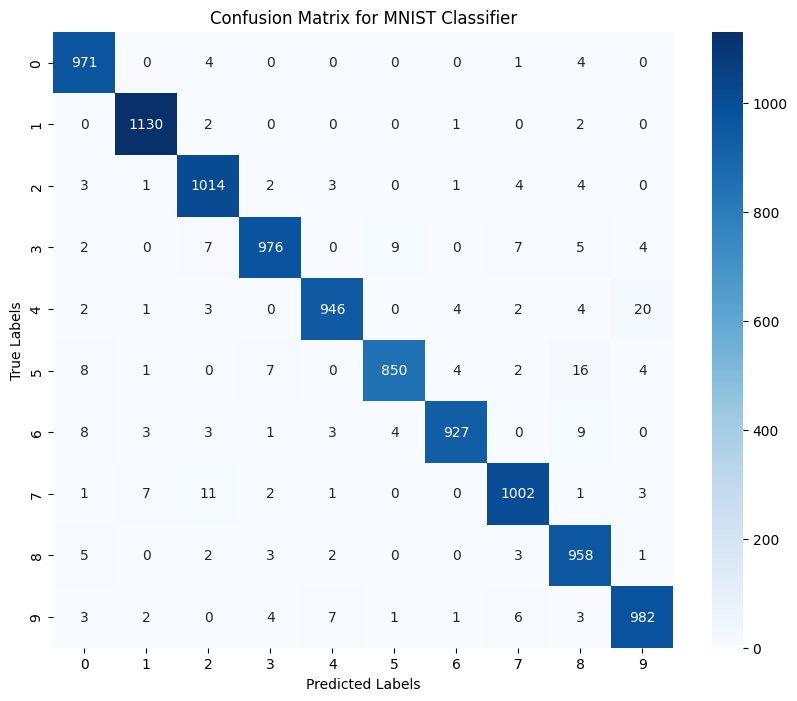

In [35]:
# Let's have a look at the MNIST test data and generate a confusion matrix:
# Get the true and predicted labels
true_labels, predicted_labels = ic.evaluate_model(model_elu, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MNIST Classifier')
plt.show()

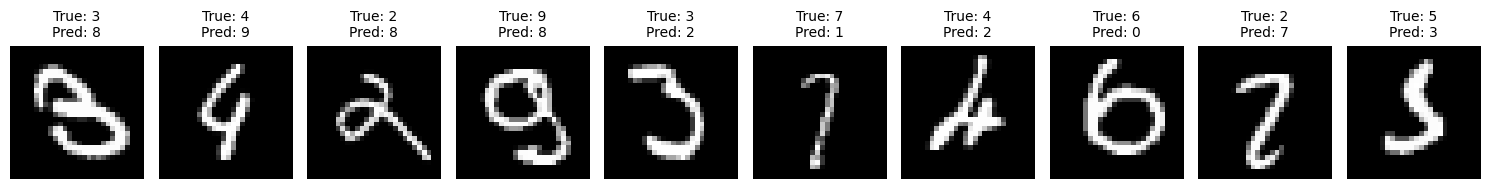

In [36]:
# examples of mislabeled numbers
ic.plot_mislabeled_images(model_elu, test_loader, device, num_examples=10)

# Blended activations

In [36]:
# Step 2: Define the model
model_blend = ic.BlendedNN()
summary(model_blend, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_blend.parameters(), lr=0.001)

In [40]:
#  Train Model
ic.train_model(model_blend, optimizer, criterion, train_loader)

epochs to run: 5
Epoch 1/5, Loss: 0.3994
Epoch 2/5, Loss: 0.1897
Epoch 3/5, Loss: 0.1384
Epoch 4/5, Loss: 0.1126
Epoch 5/5, Loss: 0.0978


In [41]:
train_acc = ic.evaluate_accuracy(model_blend, train_loader, device)
test_acc = ic.evaluate_accuracy(model_blend, test_loader, device)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 97.49%
Test Accuracy: 96.67%


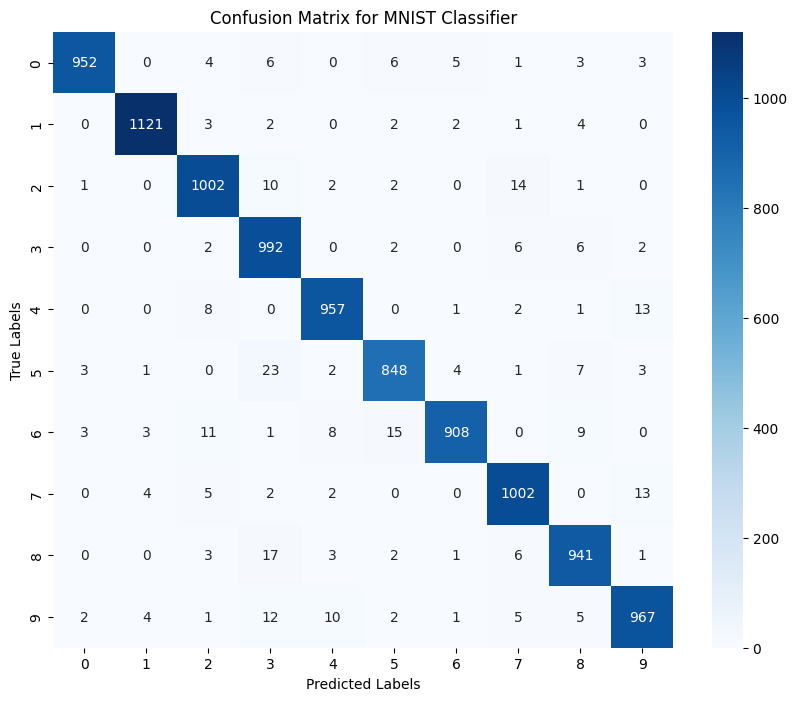

In [42]:
# Let's have a look at the MNIST test data and generate a confusion matrix:
# Set up the MNIST dataset for testing

# Do you have a GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the true and predicted labels
true_labels, predicted_labels = ic.evaluate_model(model_blend, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MNIST Classifier')
plt.show()

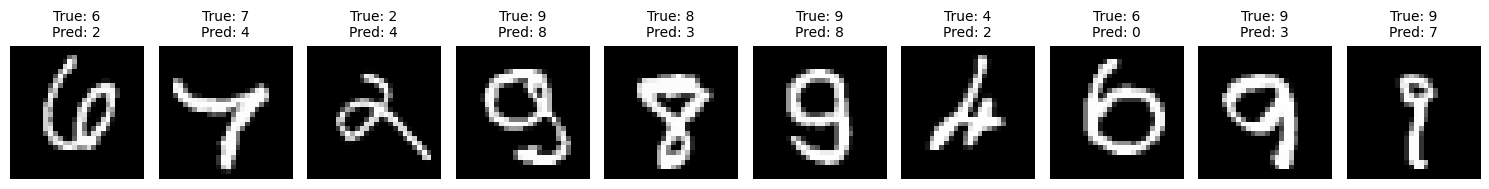

In [43]:
# examples of mislabeled numbers
ic.plot_mislabeled_images(model_blend, test_loader, device, num_examples=10)

# Running Final Validations with ELU

In [54]:
train_val_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [56]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch 1/10, Train Loss: 0.4416, Val Loss: 0.2883
Epoch 2/10, Train Loss: 0.2589, Val Loss: 0.2341
Epoch 3/10, Train Loss: 0.2087, Val Loss: 0.2445
Epoch 4/10, Train Loss: 0.1866, Val Loss: 0.1729
Epoch 5/10, Train Loss: 0.1797, Val Loss: 0.1680
Epoch 6/10, Train Loss: 0.1658, Val Loss: 0.1623
Epoch 7/10, Train Loss: 0.1665, Val Loss: 0.1844
Epoch 8/10, Train Loss: 0.1590, Val Loss: 0.1527
Epoch 9/10, Train Loss: 0.1582, Val Loss: 0.1627
Epoch 10/10, Train Loss: 0.1528, Val Loss: 0.1627


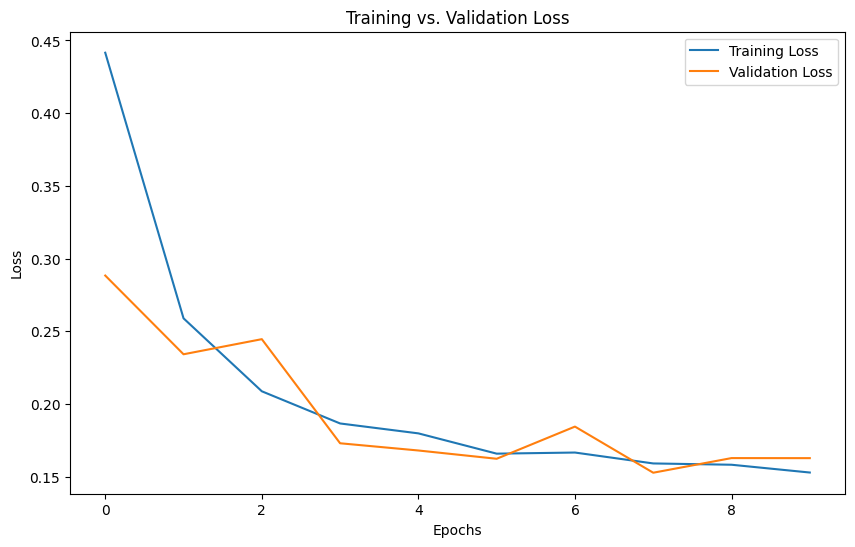

In [62]:
# Call the training function
alpha  = 0.1
model_elu = ic.SimpleNN(activation_function=lambda: nn.ELU(alpha=alpha))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_elu.parameters(), lr=0.001,weight_decay=0.005) # weight decay is ridge regression
train_losses, val_losses = ic.train_and_validate(model_elu, train_loader, val_loader, criterion, optimizer, device, epochs=10)

# Plot the losses
# Looking for either a continuous decrease in the training loss or a plateau in the validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()
# Looks like 5 epochs with some regularization works fine

In [46]:
alpha  = 0.5
model_elu = ic.SimpleNN(activation_function=lambda: nn.ELU(alpha=alpha))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_elu.parameters(), lr=0.001,weight_decay=0.001)
ic.train_model(model_elu, optimizer, criterion, train_loader, epochs = 5)
torch.save(model.state_dict(), "model.pth")
# reload with the following code:
# model = SimpleNN()
# model.load_state_dict(torch.load("model.pth"))
# model.eval()

epochs to run: 5
Epoch 1/5, Loss: 0.3561
Epoch 2/5, Loss: 0.1793
Epoch 3/5, Loss: 0.1387
Epoch 4/5, Loss: 0.1190
Epoch 5/5, Loss: 0.1071


In [63]:
train_acc = ic.evaluate_accuracy(model_elu, train_loader, device)
test_acc = ic.evaluate_accuracy(model_elu, test_loader, device)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 96.07%
Test Accuracy: 95.50%
